In [3]:
import matplotlib.pyplot as plt
import urllib.request, json
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

2024-09-20 20:07:33.505938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 20:07:33.528367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 20:07:33.528399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 20:07:33.541336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 20:07:34.381896: W tensorflow/compiler/tf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
plt.rcParams['figure.figsize'] = (5, 5)
plt.rc('font', size=5)

Num GPUs Available:  1


2024-09-20 20:07:36.710388: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 20:07:36.758639: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-20 20:07:36.759757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
res = urllib.request.urlopen("http://127.0.0.1:8000/api/vagas?treinamento=true")
data = json.loads(res.read())
exemplos_treinamento = data['data']
qtd_pos = data['qtd_pos']
qtd_neg = data['qtd_neg']

In [6]:
sentences = []
pos = []
maxlen = 46

def converteTextoParaTokens(texto : str):
    tokens = list(map(lambda x: str(x).lower(), tokenizer.tokenize(texto)))
    for i in range(len(tokens)):
        if tokens[i].isdigit():
            tokens[i] = "num"
    return tokens

for exemplo in exemplos_treinamento:
    tokens = converteTextoParaTokens(exemplo['txtVaga'])
    aplicacao = exemplo['isApplied']
    sentences.append(tokens)
    pos.append([int(bool(aplicacao))])
    
    if len(tokens) > maxlen:
        maxlen = len(tokens)
        print("Maxlen atualizado: ",  maxlen)

In [7]:
word_list = ['<pad>'] + sorted(set(sum(sentences, []))) + ['_UNKNOWN']
word2idx = {word:idx for idx, word in enumerate(word_list)}
idx2word = {idx:word for idx, word in enumerate(word_list)}
pos_list = sorted(set(sum(pos, [])))
pos2idx = {pos:idx for idx, pos in enumerate(pos_list)}
idx2pos = {idx:pos for idx, pos in enumerate(pos_list)}
X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], sentences))
y = list(map(lambda sentence: [pos2idx.get(token) for token in sentence], pos))
X = pad_sequences(X, maxlen=maxlen, padding='post')
X_mask = (X != 0).astype(np.float32)
X_len = np.array(list((map(lambda sentence: len(sentence), sentences))), dtype=np.float32)
y = pad_sequences(y, maxlen=1, padding='post')

json_str = json.dumps(word2idx, ensure_ascii=False)
json_str = json.loads(json_str)
with open('char2idx.json', 'w', encoding='utf-8') as json_file:
    json.dump(json_str, json_file, ensure_ascii=False)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8551 - auc: 0.5937 - fn: 65.6216 - fp: 1601.2972 - loss: 0.6781 - prc: 0.0351 - precision: 0.0303 - recall: 0.4607
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.8796 - auc: 0.8425 - fn: 21.5946 - fp: 1439.4324 - loss: 0.5316 - prc: 0.1423 - precision: 0.0590 - recall: 0.8305
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9334 - auc: 0.9380 - fn: 13.7838 - fp: 697.5405 - loss: 0.4761 - prc: 0.2661 - precision: 0.1426 - recall: 0.8902
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9579 - auc: 0.9753 - fn: 7.2162 - fp: 436.7027 - loss: 0.3958 - prc: 0.4452 - precision: 0.2199 - recall: 0.9445
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9640 - auc: 0.9806 - fn: 7.0270 - fp: 373.9189 - loss: 0.3510 - prc: 0.5091 - precision: 0.2159 - recall: 0.9369
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9674 - auc: 0.9888 - fn: 2.2703 - fp: 26

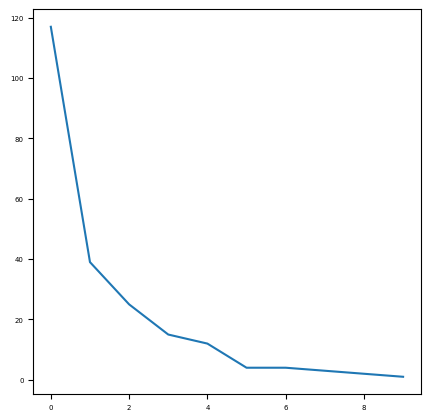

In [11]:

num_classes = len(pos2idx)
input_dim = len(word2idx)
output_dim = len(word2idx)
exemples_dim = len(sentences)
batch_size = 300
epochs = 10

optimizer = Adam()

loss_function = BinaryCrossentropy()
additional_metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.6),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

model = Sequential()
model.add(Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=True,
    embeddings_initializer=tf.keras.initializers.random_normal
))
model.add(SimpleRNN(units=3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
#model.summary()

weight_for_0 = (1 / qtd_neg) * (exemples_dim / 2.0)
weight_for_1 = (1 / qtd_pos) * (exemples_dim / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

history = model.fit(X, y, class_weight=class_weight, batch_size=batch_size, shuffle=True, epochs=epochs, verbose=True)

plt.figure()
plt.plot(history.history['fn'])
plt.show()

In [ ]:
# Exemplo de inferência
novo_X = [['desenvolvedor', 'web', 'java','junior']]
novo_X = list(map(lambda sentence: [word2idx.get(token) for token in sentence], novo_X))
novo_X = pad_sequences(novo_X, maxlen=maxlen, padding='post')
y_pred = model.predict(novo_X, batch_size=1)[0]
y_pred

In [12]:
model.save("model.keras")